In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
url = 'https://raw.githubusercontent.com/Ciarzi/DP3_GP1/main/datasets/own_data/cluster_train.csv'
df = pd.read_csv(url)

# Formateo de los datos
Separamos las columnas que usaremos para realizar clasificaciones (*x*) de las columnas que queremos predecir (*y*).

In [3]:
x = df.loc[:,df.columns!='flag']
y = df.loc[:,'flag']
x.shape, y.shape, df.shape

((4358, 12), (4358,), (4358, 13))

Las dos opciones no están representadas de manera proporcionada, por lo que estratificamos la muestra para que haya el mismo porcentaje de personas que han pagado el préstamo en el training set y en el testing set.

In [4]:
sum(y)/len(y) #Obtenemos el porcentaje de personas que han pagado el préstamo

0.7824690224873795

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 40, stratify = y) #Obtenemos 4 datasets


In [6]:
sum(y_train/len(y_train)) #Datos de entrenamiento

0.7824357405140463

In [7]:
sum(y_test/len(y_test)) #Datos de test

0.7825688073394335

# Optimización (PCA)
Reducirá las features correlacionadas para reducir las dimensiones, comprobamos si aumenta la accuracy

In [8]:
pca = PCA(n_components = 1)
x_train_scaled = pca.fit_transform(x_train)
print(x_train_scaled[:10])

[[ 369.76147994]
 [  73.59310326]
 [-309.49022303]
 [-309.48742607]
 [-309.48536232]
 [-309.48713672]
 [  73.61387343]
 [-309.48641118]
 [-309.48774939]
 [ -92.49740509]]


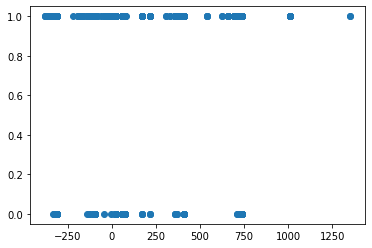

In [26]:
plt.scatter(x_train_scaled, y_train)
plt.show()
#al haber reducido las dimensione vemos que no hay una correlación directa

# Creación del modelo con XGBoost usando XGBClassifier
Empleamos LOGLOSS ya que tiene en cuenta la certeza de la clasificación y es la mejor opción en caso de que los datos a analizar no estén balanceados.

In [10]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', #clasificar entre 0 y 1
                            missing = None,
                            seed = 24) 
clf_xgb.fit(x_train,
            y_train,
            verbose = True, # nos informa de lo que está haciendo
            early_stopping_rounds = 10, #si en estas rondas no mejora el score (función de pérdida) detendrá el entrenamiento
            eval_metric = 'logloss', #evalua lo bunas que son las predicciones
            eval_set = [(x_test, y_test)]) #entrena en el dataset de entrenameinto pero evalua cuantos arboles debe crear usando el testing dataset

[0]	validation_0-logloss:0.656619
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.627135
[2]	validation_0-logloss:0.6025
[3]	validation_0-logloss:0.582252
[4]	validation_0-logloss:0.565862
[5]	validation_0-logloss:0.551838
[6]	validation_0-logloss:0.539746
[7]	validation_0-logloss:0.530104
[8]	validation_0-logloss:0.521933
[9]	validation_0-logloss:0.515122
[10]	validation_0-logloss:0.509534
[11]	validation_0-logloss:0.50508
[12]	validation_0-logloss:0.500994
[13]	validation_0-logloss:0.497441
[14]	validation_0-logloss:0.494808
[15]	validation_0-logloss:0.492567
[16]	validation_0-logloss:0.490932
[17]	validation_0-logloss:0.489166
[18]	validation_0-logloss:0.487895
[19]	validation_0-logloss:0.486886
[20]	validation_0-logloss:0.485823
[21]	validation_0-logloss:0.485074
[22]	validation_0-logloss:0.484582
[23]	validation_0-logloss:0.484122
[24]	validation_0-logloss:0.48381
[25]	validation_0-logloss:0.48355
[26]	validation_0-logloss:0.483379
[2

XGBClassifier(seed=24)

Comprobamos en el dataset de test y dibujamos una matriz de confusión.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


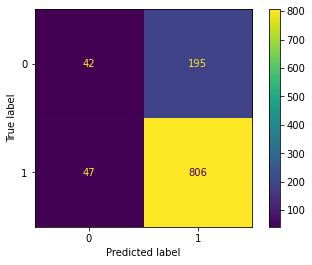

In [11]:
plot_confusion_matrix(clf_xgb,
                      x_test,
                      y_test,
                      values_format = 'd')

#Pruebas parar mejorar el resultado
De las 237 personas que no han pagado, hemos clasificado bien a 195 (**83,54%**) y de las 853 personas que han pagado, hemos clasificado bien a 860 (**96,13%**). Como los datos no están repartidos correctamente (237 contra 820) hemos de obtener más datos de personas que no pagaron, por lo que cuando configuremos los hiperparámetros usaremos la función ```
scale_pos_weight``` para obtener un mejor resultado 🙂

In [12]:
#Ronda 1
param_grid = {
    'max_depth' : [3, 4, 5], #La profundidad de los árboles de decisión
    'learning_rate' : [0.1, 0.01, 0.05], #La frecuencia con la que la red neuronal refresca lo que ha aprendido
    'gamma' : [0, 0.25, 1.0], # Reduce el tamaño de los árboles de decisión al eliminar secciones del árbol que no son necesarias
    'reg_lambda' : [0, 1.0, 10.0], # Gestiona el overfitting
    'scale_pos_weight' : [1, 3, 5] 
}

In [16]:
#Ronda 2
param_grid = {
    'max_depth' : [3],
    'learning_rate' : [0.01],
    'gamma' : [1],
    'reg_lambda' : [1],
    'scale_pos_weight' : [1]
}

In [17]:
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  seed = 24,
                                  subsample = 0.9, # Para acelerar las validación cruzada empleamos un subset aleatorio del 90% (por árbol)
                                  colsample_bytree = 0.5), # Elegimos (por arbol) el 50% de las columnas del dataset para reducir el overfitting (y la velocidad)
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 3
)

In [18]:
optimal_params.fit(x_train,
                   y_train,
                   verbose = True,
                   early_stopping_rounds = 10,
                   eval_metric = 'logloss',
                   eval_set = [(x_test, y_test)])
print(optimal_params.best_params_)

[0]	validation_0-logloss:0.689334
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.686071
[2]	validation_0-logloss:0.682482
[3]	validation_0-logloss:0.679359
[4]	validation_0-logloss:0.675839
[5]	validation_0-logloss:0.672875
[6]	validation_0-logloss:0.669523
[7]	validation_0-logloss:0.666198
[8]	validation_0-logloss:0.663332
[9]	validation_0-logloss:0.660557
[10]	validation_0-logloss:0.657413
[11]	validation_0-logloss:0.654349
[12]	validation_0-logloss:0.651292
[13]	validation_0-logloss:0.648303
[14]	validation_0-logloss:0.645784
[15]	validation_0-logloss:0.643303
[16]	validation_0-logloss:0.640462
[17]	validation_0-logloss:0.637678
[18]	validation_0-logloss:0.63525
[19]	validation_0-logloss:0.632958
[20]	validation_0-logloss:0.630656
[21]	validation_0-logloss:0.628351
[22]	validation_0-logloss:0.626079
[23]	validation_0-logloss:0.623572
[24]	validation_0-logloss:0.621122
[25]	validation_0-logloss:0.618951
[26]	validation_0-logloss:0.61683

# Validamos el conjunto de entrenamiento (*x_train* e *y_train*)

In [19]:
optimal_params.best_estimator_

XGBClassifier(colsample_bytree=0.5, gamma=1, learning_rate=0.01, seed=24,
              subsample=0.9)

In [20]:
optimal_params.best_score_

0.700152357687549

In [21]:
best_xgb = optimal_params.best_estimator_
y_preds = best_xgb.predict(x_train)

comp = pd.DataFrame ({'Datos' : y_train, 'Predicciones' : y_preds}) # Creamos el dataframe de comparación
comp.head(10)

,Datos,Predicciones
1341,1,1
2205,0,1
3650,1,1
1273,1,1
1200,1,1
717,0,1
1407,1,1
2338,0,1
4236,1,1
1768,1,1


In [22]:
acc = accuracy_score(y_train, y_preds) # Comprobamos el ratio de acierto
acc

0.7858017135862914

#Presentación del árbol de decisión
Repetimos el código anterior, pero indicando que solo queremos crear el primer arbol para poder dibujarlo.
¿Lo entiendo? Vagamente.  ¿Es bonito? Para nada. ✅

In [23]:
clf_xgb = xgb.XGBClassifier(seed = 20,
                            objective = 'binary:logistic',
                            gamma = 1,
                            learn_rate = 0.05,
                            max_depth = 5,
                            reg_lambda = 0,
                            scale_pos_weight = 3,
                            subsample = 0.9,
                            colsampole_bytree = 0.5,
                            n_estimators = 1) #Indicamos solo un árbol
clf_xgb.fit(x_train, y_train)

XGBClassifier(colsampole_bytree=0.5, gamma=1, learn_rate=0.05, max_depth=5,
              n_estimators=1, reg_lambda=0, scale_pos_weight=3, seed=20,
              subsample=0.9)

In [24]:
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
  print('%s: ' % importance_type, bst.get_score(importance_type = importance_type))

weight:  {'historial': 1, 'loannumber': 4, 'employment': 3, 'interes': 6, 'age': 4, 'parte_mes_pago': 3, 'due_per_day': 4, 'cuenta_ahorro': 1}
gain:  {'historial': 93.9023438, 'loannumber': 10.3686986075, 'employment': 4.46895345, 'interes': 4.2318143856666675, 'age': 5.253263717499999, 'parte_mes_pago': 4.46919759, 'due_per_day': 5.190403945, 'cuenta_ahorro': 4.86273193}
cover:  {'historial': 1885.5, 'loannumber': 290.0, 'employment': 562.5, 'interes': 408.0, 'age': 167.0, 'parte_mes_pago': 267.5833333333333, 'due_per_day': 120.75, 'cuenta_ahorro': 189.25}
total_gain:  {'historial': 93.9023438, 'loannumber': 41.47479443, 'employment': 13.406860349999999, 'interes': 25.390886314000003, 'age': 21.013054869999998, 'parte_mes_pago': 13.40759277, 'due_per_day': 20.76161578, 'cuenta_ahorro': 4.86273193}
total_cover:  {'historial': 1885.5, 'loannumber': 1160.0, 'employment': 1687.5, 'interes': 2448.0, 'age': 668.0, 'parte_mes_pago': 802.75, 'due_per_day': 483.0, 'cuenta_ahorro': 189.25}


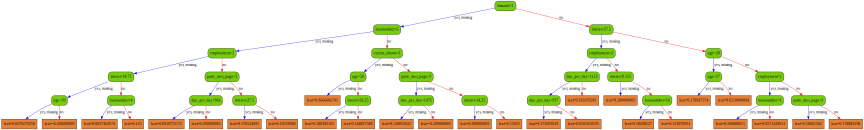

In [25]:
node_params = {'shape' : 'box',
               'style' : 'filled, rounded',
               'fillcolor' : '#78cbe'}
leaf_params = {'shape' : 'box',
               'style' : 'filled',
               'fillcolor' : '#e48038'}

xgb.to_graphviz(clf_xgb,
                num_trees = 0,
                size = "12,12",
                condition_node_params = node_params,
                leaf_node_params = leaf_params)